# Imports

In [25]:
import pandas as pd
import numpy as np
import cv2
import os 
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
import datetime
import urllib.request


# Data Preprocessing

In [26]:
def get_df_from_dir(dir_path):
    imgs = []
    y = []
    for file in os.listdir(dir_path):
        path = dir_path + file
        img = cv2.imread(path)
        imgs.append(img)
    imgs = np.array(imgs)/255
    y = [0 if 'REAL' in dir_path else 1 for i in range(len(imgs))]
    return imgs, y

In [27]:
def preprocess_data(file):
    img = cv2.imread(file)
    img = cv2.resize(img, (32, 32))
    return img

In [28]:
train_real_path = '../data/train/REAL/'
train_fake_path = '../data/train/FAKE/'
test_real_path = '../data/test/REAL/'
test_fake_path = '../data/test/FAKE/'

In [29]:
train_real_imgs, train_real_y = get_df_from_dir(train_real_path)
train_fake_imgs, train_fake_y = get_df_from_dir(train_fake_path)
test_real_imgs, test_real_y = get_df_from_dir(test_real_path)
test_fake_imgs, test_fake_y = get_df_from_dir(test_fake_path)

In [30]:
X = np.concatenate((train_real_imgs, train_fake_imgs))
y = np.concatenate((train_real_y, train_fake_y))
X_test = np.concatenate((test_real_imgs, test_fake_imgs))
y_test = np.concatenate((test_real_y, test_fake_y))

In [32]:
X.shape, y.shape, X_test.shape, y_test.shape

((100000, 32, 32, 3), (100000,), (20000, 32, 32, 3), (20000,))

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Model Training


## CNN model

In [14]:
def initialize_cnn_model():
    model = models.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Dropout(0.25))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [50]:
model = initialize_cnn_model()

In [51]:
def compile_model(learning_rate=1e-4):
    model = initialize_cnn_model()
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


In [15]:
def save_model(model, name):
    model.save(f"../model/{name}" + '.h5')

def load_model(name):
    return models.load_model(f"../model/{name}" + '.h5')


In [16]:
def train_model(
        X_train,
        y_train,
        X_val,
        y_val,
        epochs=100,
        batch_size=32,
        patience=5
        ):
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    model = compile_model()
    history = model.fit(
        X_train, 
        y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val, y_val),
        callbacks=[es]
        )
    accuracy = round(history.history['accuracy'][-1], 2)
    date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    save_model(model, f"model_{accuracy}_{date}")
    return model, history

In [62]:
model, history = train_model(X_train, y_train, X_val, y_val, epochs=1000, batch_size=32, patience=5)

Epoch 1/1000
 566/2500 [=====>........................] - ETA: 24s - loss: 0.7200 - accuracy: 0.5515

KeyboardInterrupt: 

In [61]:
model = load_model('model_0.9490749835968018_20230605-152407')

In [18]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

plot_history(history)

NameError: name 'history' is not defined

In [11]:
train_accuracy = history.history['accuracy'][-1]
train_accuracy

NameError: name 'history' is not defined

In [19]:
test_accuracy = model.evaluate(X_test, y_test)[1]

625/625 [==============================] - 2s 4ms/step - loss: 0.1573 - accuracy: 0.9508


In [82]:
y_test[6000]

0

In [83]:

X_test_1 = np.expand_dims(X_test[6000], axis=0)
y_pred = model.predict(X_test_1)
y_pred

1/1 [==============================] - 0s 11ms/step


array([[0.01325815]], dtype=float32)

1/1 [==============================] - 0s 77ms/step - loss: 0.5946 - accuracy: 1.0000


[0.5945842266082764, 1.0]

In [20]:
test_accuracy

0.9508000016212463

## Transfer Learning

### VGG16


In [17]:
def load_model_VGG16():
    model = keras.applications.VGG16(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(32, 32, 3),
        include_top=False
        )  # Do not include the ImageNet classifier at the top.
    return model

In [19]:
def set_nontrainable_layers(model):
    model.trainable = False
    return model

In [23]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    rescale_layer = layers.Rescaling(1./255, input_shape=(32, 32, 3))
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')
    
    
    model = models.Sequential([
        
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    return model
    

In [ ]:
def add_rescale_layer():

In [20]:
def build_model():
    model = load_model_VGG16()
    model = add_last_layers(model)

    adam = optimizers.Adam(learning_rate=1e-4)

    model.compile(
        optimizer=adam,
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall']
    )
    return model

In [21]:
def train_model(
        X_train,
        y_train,
        X_val,
        y_val,
        epochs=100,
        batch_size=32,
        patience=5
        ):
    es = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        )
    model = build_model()
    history = model.fit(
        X_train, 
        y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val, y_val),
        callbacks=[es]
        )
    accuracy = round(history.history['accuracy'][-1], 2)
    date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    save_model(model, f"model_{accuracy}_{date}")
    return model, history

In [34]:
model, history = train_model(X_train, y_train, X_val, y_val, epochs=1000, batch_size=32, patience=5)

Epoch 1/1000


2023-06-06 11:36:23.295354: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2500/2500 [==============================] - 164s 65ms/step - loss: 0.4045 - accuracy: 0.8177 - precision: 0.8183 - recall: 0.8173 - val_loss: 0.3556 - val_accuracy: 0.8457 - val_precision: 0.8432 - val_recall: 0.8472
Epoch 2/1000
2080/2500 [=======================>......] - ETA: 22s - loss: 0.3446 - accuracy: 0.8495 - precision: 0.8503 - recall: 0.8498

KeyboardInterrupt: 

In [ ]:
res = model.evaluate(X_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix

y_prediction = model.predict(X_test)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

# Test on real images 

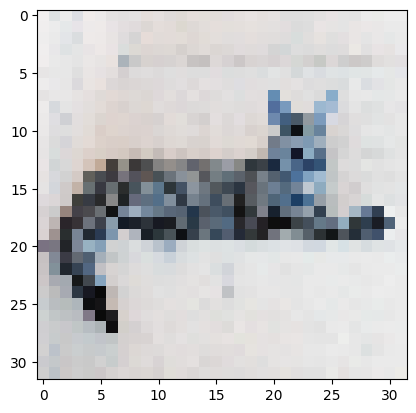

In [71]:
url = 'https://upload.wikimedia.org/wikipedia/commons/1/15/Cat_August_2010-4.jpg'
res = urllib.request.urlopen(url)
img = cv2.imdecode(np.asarray(bytearray(res.read())), 1)
img = cv2.resize(img, (32, 32))
plt.imshow(img)

In [111]:
def test_img(url, model):
    res = urllib.request.urlopen(url)
    img = cv2.imdecode(np.asarray(bytearray(res.read()), dtype=np.uint8), 1)
    img = cv2.resize(img, (32, 32))
    img = img/255.
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    return model.predict(img)


def test_img_local(path, model):
    img = cv2.imread(path)
    img = cv2.resize(img, (32, 32))
    img = img/255.
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    return model.predict(img)

In [115]:
test_img_local('/Users/aminebenani/Downloads/IMG_0267_crop.png', model)

(1, 32, 32, 3)
1/1 [==============================] - 0s 10ms/step


array([[0.97634786]], dtype=float32)